In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import RandomizedSearchCV

from sklearn.utils import resample

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
pd.read_csv('sample_submission.csv').head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [7]:
X = train_df['message']
y = train_df['sentiment']

In [8]:
anti = train_df[y==-1]
neutral = train_df[y==0]
pro = train_df[y==1]
news = train_df[y==2]

y.value_counts()


 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

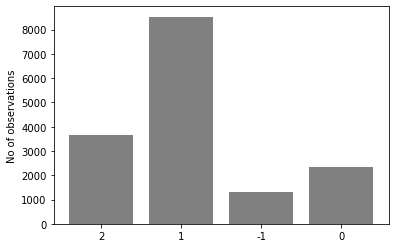

In [9]:
labels = y.unique()
heights = [len(anti),len(neutral),len(pro),len(news)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['-1','0','1','2'])
plt.ylabel("No of observations")
plt.show()

Data Cleaning

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
#replace all urls with 'url'
def remove_url(df):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    url = r'url'
    df['message'] = df['message'].replace(to_replace = pattern_url, value = url, regex = True)
    return df

In [12]:
train_df = remove_url(train_df)
test_df = remove_url(test_df)

In [13]:
# add stopwords
for word in ['RT','https','http','rt']:
    spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS
    spacy_stop_words.add(word)

In [14]:
#remove unwanted words eg 'aaa' and incorrect words and then lowering every text
def clean_message(message):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z\t])|(\w+:\/\/\S+)"," ",message).split())

train_df['message'] = train_df['message'].apply(clean_message).str.lower()
test_df['message'] = test_df['message'].apply(clean_message).str.lower()

In [15]:
#Remove all punctuation and numbers in message column
def remove_punctuation(message):
    punct = string.punctuation +'0123456789'
    return ''.join([l for l in message if l not in punct])
train_df['message'] = train_df['message'].apply(remove_punctuation)
test_df['message'] = test_df['message'].apply(remove_punctuation)

In [16]:
def replace_text(message):
    #message = re.sub(r'yrs','years',message)
    #message = re.sub(r'yr','year',message)
    message = re.sub(r'ivotedbecause','I voted because',message)
    message = re.sub(r'globalwarming','global warming',message)
    #message = re.sub(r'yr','year',message)
    message = re.sub(r'exxonmobil','exxon mobile',message)
    message = re.sub(r'mobil\S+','mobile',message)
    message = re.sub(r'climatechange','climate change',message)
    message = re.sub(r'climatemarch','climate march',message)
    message = re.sub(r'beforetheflood','before the flood',message)
    message = re.sub(r'betwe|betwe\S+','between',message)
    message = re.sub(r'actonclimate','act on climate',message)
    
    
    
    return message
train_df['message'] = train_df['message'].apply(replace_text)
test_df['message'] = test_df['message'].apply(replace_text)  

In [17]:
#lemmatizing the texts
def lemma_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

train_df['message'] = train_df['message'].apply(lemma_text)
test_df['message'] = test_df['message'].apply(lemma_text)

#Data Cleaned

In [18]:
X = train_df['message']
tfidf = TfidfVectorizer(strip_accents='ascii',stop_words= spacy_stop_words,min_df=2,sublinear_tf=True,norm='l2',ngram_range=(1,2))
X_vectorized = tfidf.fit_transform(X)

C:\Users\Mathew\anaconda3\envs\Climate_Change_Belief_Analysis\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [19]:
smote = SMOTE(random_state =42)
X_vect_smote, y_smote = smote.fit_sample(X_vectorized,y)

In [20]:
len(y_smote)

34120

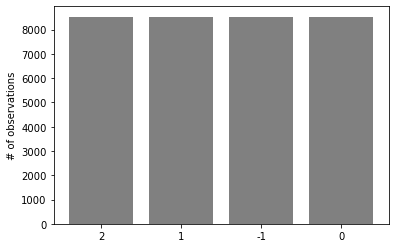

In [21]:
anti = y_smote[y_smote==-1]
neutral = y_smote[y_smote==0]
pro = y_smote[y_smote==1]
news = y_smote[y_smote==2]
labels = y_smote.unique()
heights = [len(anti),len(neutral),len(pro),len(news)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['-1','0','1','2'])
plt.ylabel("# of observations")
plt.show()

In [22]:
print(tfidf.get_feature_names())


['aaaand', 'ab', 'ab climate', 'ab url', 'abandon', 'abandon climate', 'abandon coal', 'abandon coast', 'abandon deal', 'abandon global', 'abandon hope', 'abandon pron', 'abbott', 'abc', 'abc news', 'abc online', 'abc point', 'ability', 'able', 'ableg', 'abolish', 'abolishe', 'abolishe climate', 'aboriginal', 'abortion', 'abortion anti', 'abortion climate', 'abortion gay', 'abortion sex', 'abortion url', 'abou', 'abound', 'abound amid', 'abraham', 'abraham url', 'abraham vote', 'abroad', 'abrupt', 'abrupt climate', 'abruptly', 'abruptly cancel', 'absolute', 'absolutely', 'absolutely disgusting', 'absorb', 'abstract', 'absurd', 'abt', 'abt climate', 'abt global', 'abt pron', 'abuse', 'ac', 'aca', 'academic', 'academics', 'academy', 'academy tell', 'accelerant', 'accelerant instability', 'accelerate', 'accelerate climate', 'accelerate global', 'accelerate pron', 'accelerate trump', 'accelerate url', 'accept', 'accept climate', 'accept fact', 'accept global', 'accept pron', 'accept scienc

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_vect_smote, y_smote,test_size=0.3,random_state=42)

In [24]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier()
]

In [25]:
results = []

names = ['Logistic Regression', 'Nearest Neighbors',
         'SVM','Decision Tree', 'Random Forest','AdaBoost Classifier','MLPClassifier']
for clf, name in zip(classifiers, names):
    model = clf
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    
    f1 = metrics.f1_score(y_val, y_pred, average='macro')
    results.append([name, f1])
results = pd.DataFrame(results, columns=['Classifier', 'F1 Score'])  

C:\Users\Mathew\anaconda3\envs\Climate_Change_Belief_Analysis\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
results.sort_values('F1 Score', ascending=False)

,Classifier,F1 Score
2,SVM,0.912020
6,MLPClassifier,0.906148
4,Random Forest,0.880022
0,Logistic Regression,0.862671
3,Decision Tree,0.751530
1,Nearest Neighbors,0.693799
5,AdaBoost Classifier,0.633830


In [27]:
X_test = test_df['message']
test_vectorized = tfidf.transform(X_test)

In [28]:
#X_test_df = test_df['message']

In [29]:
#test_vectorized = tfidf.transform(X_test_df)

In [31]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
rfc_val_pred = rfc.predict(X_val)
f1 = metrics.f1_score(y_val, rfc_val_pred, average='macro')
f1

0.8803844593795246

In [33]:
rfc_test_pred = rfc.predict(test_vectorized)

In [34]:
svc = SVC()
svc.fit(X_train, y_train)
svc_val_pred = svc.predict(X_val)
f1 = metrics.f1_score(y_val, svc_val_pred, average='macro')
f1

0.9120201517634652

In [35]:
svc_test_pred = svc.predict(test_vectorized)

In [36]:
test_df['sentiment'] = svc_test_pred
test_df[['tweetid','sentiment']].to_csv('svc_test_.csv', index=0)

In [37]:
test_df[['tweetid','sentiment']]

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0


In [ ]:
#best_params = {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}

In [ ]:
#params = {'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'kernel':['rbf','poly'],'degree':[3,4,5],'gamma':['scale','auto'],'class_weight':[None,'balanced'],
#         'decision_function_shape':['ovr','ovo']}
#grid = RandomizedSearchCV(svc,param_distributions=params,random_state=42)
#grid.fit(X_train,y_train)
#grid_pred = grid.predict(X_val)


In [ ]:
#grid.best_params_

In [ ]:
#grid.best_score_

In [ ]:
#grid.best_estimator_

In [ ]:
#grid_test_pred = grid.predict(test_vectorized)

In [ ]:
#grid.cv_results_

In [ ]:
#test_df['sentiment'] = grid_test_pred
#test_df[['tweetid','sentiment']].to_csv('random_test_89.csv', index=0)

In [ ]:
#svc_best = {'kernel': 'rbf','gamma': 'scale','degree': 4,'decision_function_shape': 'ovr','class_weight': 'balanced','C': 0.6}

In [ ]:
X = np.array(X_vect_smote)
y = np.array(y_vect_smote)